In [9]:
from cvxpy import *
from numpy import array
import numpy
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from mlxtend.data import loadlocal_mnist
import time
import gzip

In [7]:
def plotting(x,y,a,b,t):
    #  Hyperplane a'x -b = 0, t is the width
    
    plt.ylim([-5,5])
    plt.xlim([-5,5])
    plt.scatter(x[:,0], x[:,1], c='b', marker='o')
    plt.scatter(y[:,0], y[:,1], c='r', marker='x')
    d1_min = np.min([x[:,0]])
    d1_min1 = np.min([y[:,0]])
    if d1_min > d1_min1:
        d1_min=d1_min1
    d1_max = np.max([x[:,0]])
    d1_max1 = np.max([y[:,0]])
    if d1_max < d1_max1:
        d1_max=d1_max1
    # Line form: (-a[0] * x - b ) / a[1]
    d2_atD1min = (-a[0]*d1_min + b ) / a[1]
    d2_atD1max = (-a[0]*d1_max + b ) / a[1]

    sup_up_atD1min = (-a[0]*d1_min + b + t ) / a[1]
    sup_up_atD1max = (-a[0]*d1_max + b + t ) / a[1]
    sup_dn_atD1min = (-a[0]*d1_min + b - t ) / a[1]
    sup_dn_atD1max = (-a[0]*d1_max + b - t ) / a[1]

    # Plot the Lines
    plt.plot([d1_min,d1_max],[d2_atD1min,d2_atD1max],color='black')
    plt.plot([d1_min,d1_max],[sup_up_atD1min,sup_up_atD1max],'--',color='gray')
    plt.plot([d1_min,d1_max],[sup_dn_atD1min,sup_dn_atD1max],'--',color='gray')
##########################
def createdata(x):
    if x > 0:
        np.random.seed(71169)
        #np.random.seed(20610093471169)
        xp = np.random.multivariate_normal([1,1],[[1,0], [0,1]],200)
        xn = np.random.multivariate_normal([-1,-1],[[1,0], [0,1]],200)
        yp = np.ones(200)
        yn = np.multiply(np.ones(200),-1)
    else:
        np.random.seed(71169)
        #np.random.seed(20610093471169)
        xp = np.random.multivariate_normal([1,1],[[1,0], [0,1]],200)
        xn = np.random.multivariate_normal([-1,-1],[[1,0], [0,1]],200)
        yp = np.ones(200)
        yn = np.zeros(200)
    return xp,yp,xn,yn



In [8]:
##########
#Optimization
##########
def opt(c,xp,xn,yp,yn,m,n,p,pw,cross,tx,ty,ret):
    #preprocess
    w = Variable(d)
    b = Variable()
    zipp = Variable(m)
    zin = Variable(n)
    C = Parameter()
    C.value = c
    xp=np.array(xp)
    yp=np.array(yp)
    xn=np.array(xn)
    yn=np.array(yn)
    
    #Minimizing norm^2/2 + C*zi
    obj = Minimize((norm(w,2)**2/2) + C*np.ones(m)*zipp + C*np.ones(n)*zin)
#####
#####Print out the constraints value
    constraints = [w.T * xp[i] + b >= 1 - zipp[i] for i in range(m)]
    constraints.extend([w.T * xn[i] + b <= -1 + zin[i] for i in range(n)])
    constraints.extend([zipp[i] >= 0  for i in range(m)])
    constraints.extend([zin[i] >= 0  for i in range(n)])
    #print("Solving...")
    prob = Problem(obj, constraints)
    prob.solve(qcp=True)
    w = w.value
    normw=np.linalg.norm(w)
    #thi=np.arctan(w[1]/w[0])
    b = b.value
    c = C.value
    #print("Solved!")
    error = 0
    #print("wx + b >=0:")
    # if dual_value = 0, it's not a support vector
    for i in range(m):
        x = np.dot(w.T,xp[i])+b
        #print(x)
        if x<0:
            error+=1
    #print("wx + b < 0:")
    for i in range(n):
        x = np.dot(w.T,xn[i])+b
        #print(x)
        if x>=0:
            error+=1
    #print C and vector w and dual option 
    if pw>0:
        print("C=", c)
        print("w vector=",w)
        print("margin is 1/||w||=",1/normw)
        i=0
        #plotting option
    if p>0:
        plotting(xp,xn,w,b,1)
        plt.show()
        #print(constraints[399].dual_value)
        for i in range(400):
            if (constraints[i].dual_value !=0) and i<200 and (np.dot(w.T , xp[i]) + b > 1 - zipp[i].value) :
                print(xp[i],"is support vector")
            elif (constraints[i].dual_value !=0) and (np.dot(w.T , xn[i-200]) + b < (zin[i-200].value-1)) and i>=200:
                print(xn[i-200],"is support vector")
        # cross validation option
    if cross>0:
        x = np.dot(w.T,tx)+b
        #print(x)
        if x>0:
            if ty<0:
                #print("wx +b=",x,",but y is",ty)
                return 1
            else:
                return 0
        if x<0:
            if ty>0:
                #print("wx +b=",x,",but y is",ty)
                return 1
            else:
                return 0
    else:
        print("SVM empirical Error:",error,"/",m+n,"= {:.3f} %\n".format(error/(m+n)*100))
    if ret == 0:
        return error
    else:
        return w,b
###########
def crossvalid(xp,yp,m,n,p,pw):
    error=0
    #leave one out
    for i in range(m):
        xpp=list(xp)
        ypp=list(yp)
        testdatax=xpp[i]
        testdatay=ypp[i]
        del xpp[i]
        del ypp[i]
        error = error + opt(1,xpp,xn,ypp,yn,m-1,n,p,pw,1,testdatax,testdatay,0)
        #print("error=",error)
    for i in range(n):
        xnn=list(xn)
        ynn=list(yn)
        testdatax=xnn[i]
        testdatay=ynn[i]
        del xnn[i]
        del ynn[i]
        error = error + opt(1,xp,xnn,yp,ynn,m,n-1,p,pw,1,testdatax,testdatay,0)
        #print("error=",error)
    print("Cross Validation Error: {:.3f} %".format(error/(m+n)*100))

C= 0.01
w vector= [0.58333183 0.59592716]
margin is 1/||w||= 1.1991707650192347


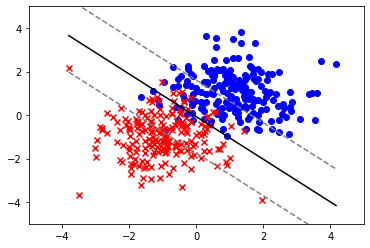

[2.82078296 0.20922974] is support vector
[ 0.83544634 -0.00972326] is support vector
[3.45188926 1.01649735] is support vector
[1.58135309 0.96427069] is support vector
[1.45789974 1.60197558] is support vector
[ 2.48245107 -0.24695737] is support vector
[2.12722204 1.90630362] is support vector
[1.33792591 3.29714896] is support vector
[0.64039232 0.63265452] is support vector
[1.29922523 0.36534954] is support vector
[-0.16857912  1.35467225] is support vector
[-1.64777644  0.82633683] is support vector
[0.91994976 1.66006275] is support vector
[0.75332262 0.30611048] is support vector
[-0.28497172  0.02803019] is support vector
[3.71904992 2.50661124] is support vector
[ 1.88072519 -0.68579352] is support vector
[0.68734562 0.12274196] is support vector
[ 2.24293872 -0.26817517] is support vector
[1.83378663 0.71635138] is support vector
[-0.61444196  0.39062933] is support vector
[0.32956077 1.43040035] is support vector
[ 3.54523385 -0.24651514] is support vector
[0.44353793 2.00

[-1.12016289 -0.83316249] is support vector
[ 0.6556988  -1.55257821] is support vector
[-1.61843101 -2.09243237] is support vector
[-1.32061826  0.73105798] is support vector
[-1.0854194  -2.88054249] is support vector
[-1.04014559  1.50357223] is support vector
[-1.36027372 -0.31042042] is support vector
[-1.16778946 -1.4732264 ] is support vector
[-0.99164678 -0.43594256] is support vector
[-0.88862499 -1.37754628] is support vector
[-1.35819426 -2.93162891] is support vector
[ 0.87086048 -2.14253478] is support vector
[-0.41317729 -0.40106996] is support vector
[ 0.78150549 -1.33004211] is support vector
[-0.6047416  -1.31795208] is support vector
[-0.59905912 -1.46470748] is support vector
[-2.49547687 -0.07214407] is support vector
[-1.95976213 -2.71619562] is support vector
[-1.36661188 -2.3986164 ] is support vector
[-1.40353042  0.68087614] is support vector
[-0.83788262 -1.45925584] is support vector
[ 0.12410235 -1.9942599 ] is support vector
[ 0.61021359 -2.34270183] is sup

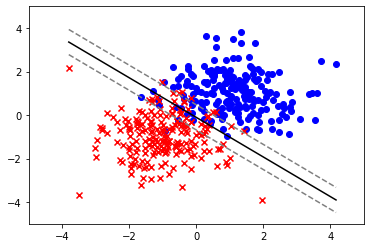

[2.82078296 0.20922974] is support vector
[ 0.83544634 -0.00972326] is support vector
[3.45188926 1.01649735] is support vector
[1.58135309 0.96427069] is support vector
[1.45789974 1.60197558] is support vector
[ 2.48245107 -0.24695737] is support vector
[2.12722204 1.90630362] is support vector
[1.33792591 3.29714896] is support vector
[0.64039232 0.63265452] is support vector
[1.29922523 0.36534954] is support vector
[-0.16857912  1.35467225] is support vector
[-1.64777644  0.82633683] is support vector
[0.91994976 1.66006275] is support vector
[0.75332262 0.30611048] is support vector
[-0.28497172  0.02803019] is support vector
[3.71904992 2.50661124] is support vector
[ 1.88072519 -0.68579352] is support vector
[0.68734562 0.12274196] is support vector
[ 2.24293872 -0.26817517] is support vector
[1.83378663 0.71635138] is support vector
[-0.61444196  0.39062933] is support vector
[0.32956077 1.43040035] is support vector
[ 3.54523385 -0.24651514] is support vector
[0.44353793 2.00

[-1.00215915 -1.18977561] is support vector
[-0.72165524 -0.70747608] is support vector
[ 1.01120969 -1.99124252] is support vector
[-0.43539906 -0.32607673] is support vector
[-0.73957823 -0.56543513] is support vector
[-1.02236383 -1.66869564] is support vector
[-0.98192019 -0.76813476] is support vector
[-1.76744637 -1.51487891] is support vector
[-1.26488505 -1.71307422] is support vector
[-1.32787272 -1.42224315] is support vector
[ 1.41905553 -0.74179264] is support vector
[-1.07719099  0.28296648] is support vector
[-1.529875   -0.70559841] is support vector
[-1.7239485  -0.88808147] is support vector
[-1.69652244 -0.46141512] is support vector
[-1.77948215 -0.58723557] is support vector
[-1.01246624 -0.6735745 ] is support vector
[ 0.15177187 -0.4311433 ] is support vector
[-1.0640767  -1.42295999] is support vector
[-0.60881385 -1.44974475] is support vector
[-2.67484998  0.09913194] is support vector
[-1.98295421 -0.67514078] is support vector
[-2.22946952 -2.17541217] is sup

28

In [5]:
d = 2 #dimension
xp=[]
xn=[]
yp=[]
yn=[]

xp,yp,xn,yn=createdata(1)
opt(0.01,xp,xn,yp,yn,200,200,1,1,0,0,0,0)
opt(100000,xp,xn,yp,yn,200,200,1,1,0,0,0,0)

In [5]:
d = 2 #dimension
xp=[]
xn=[]
yp=[]
yn=[]
m=200
n=200
start = time.time()
xp,yp,xn,yn=createdata(1)
crossvalid(xp,yp,m,n,0,0)
end = time.time()
print("Time elapsed while crossvalid: {:.3f} ".format(end - start),"s")

Cross Validation Error: 7.000 %
Time elapsed while crossvalid: 226.030  s


In [44]:

d = 784
# read data and preprocess
from mnist.loader import MNIST

mndata = MNIST('')

X_train , Y_train = mndata.load_training()
# or
X_test, Y_test = mndata.load_testing()
xp=np.empty((0,784), int)
yp=np.empty((0,1),int)
xn=np.empty((0,784), int)
yn=np.empty((0,1),int)
X_opt=np.empty((0,784), int)
Y_opt=np.empty((0,1),int)
for i in reversed(range(len(Y_train))):
    if Y_train[i] ==1:
        xp=np.append(xp,[X_train[i]],axis=0)
        yp=np.append(yp,[Y_train[i]])
    elif Y_train[i] == 0:
        xn=np.append(xn,[X_train[i]],axis=0)
        yn=np.append(yn,[Y_train[i]])

for i in reversed(range(len(Y_test))):
    if Y_test[i] ==1 or Y_test[i] == 0:
        X_opt=np.append(X_opt,[X_test[i]],axis=0)
        Y_opt=np.append(Y_opt,[Y_test[i]])
print(len(xp)+len(xn))
print("start to optimize")
start = time.time()
error = 0
w, b = opt(1,xp,xn,yp,yn,len(xp),len(xn),0,0,0,0,0,1)
print("optimization finished")
for i in range(len(Y_opt)):
    x = np.dot(w.T, X_opt[i])+b
    if x>0:
        if Y_opt[i]==0:
            #print("wx +b=",x,",but y is",ty)
            error = error +1
        else:
            error = error
    if x<0:
        if Y_opt[i]>0:
            error = error +1
        else:
            error = error
print("MNIST error {:.3f} %".format(error/len(Y_opt)*100))
end = time.time()
print("Time elapsed: {:.3f} ".format(end - start),"s")


12665
start to optimize
SVM empirical Error: 0 / 12665 = 0.000 %

optimization finished
MNIST error 0.095 %
Time elapsed: 97.580  s


In [10]:
def plotlinear(x,y,a,b,t):
    #  Hyperplane a'x -b = 0, t is the width
    
    plt.ylim([-5,5])
    plt.xlim([-5,5])
    plt.scatter(x[:,0], x[:,1], c='b', marker='o')
    plt.scatter(y[:,0], y[:,1], c='r', marker='x')
    d1_min = np.min([x[:,0]])
    d1_min1 = np.min([y[:,0]])
    if d1_min > d1_min1:
        d1_min=d1_min1
    d1_max = np.max([x[:,0]])
    d1_max1 = np.max([y[:,0]])
    if d1_max < d1_max1:
        d1_max=d1_max1
    # Line form: (-a[0] * x - b ) / a[1]
    d2_atD1min = (-a[0]*d1_min + b ) / a[1]
    d2_atD1max = (-a[0]*d1_max + b ) / a[1]
    # Plot the Lines
    plt.plot([d1_min,d1_max],[d2_atD1min,d2_atD1max],color='black')
####################################
def linear_regression(xp,yp,xn,yn,p):
    x = np.concatenate((xp,xn))
    one = np.ones(x.shape[0])
    one = one.reshape(x.shape[0],1)
    
    x = (np.concatenate((one.T, x.T)))
    x = x.T
    yp = np.array(yp)
    yn = np.array(yn)
    
    y = np.concatenate((yp,yn))
    w = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)
    x = np.concatenate((xp,xn))
    b = w[0]
    w = w[-(w.shape[0]-1):]
    
    # sign(w * x) - y (set 0 as threshold)
    error = np.sum(np.abs(np.sign(np.dot(w.reshape(1,x.shape[1]),x.T))- y)/2)
    # if value is not equal, the value after subtraction would be doubled
    if p > 0:
        print("w=",w,"b=",b)
        plotlinear(xp,xn,w,b,1)
        print("Linear regression empirical error=",error,"/",x.shape[0],"={:.3f} %".format(error/x.shape[0]*100))
    return w
##########################
def linear_regressionnmist(x,y):
    w = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)
    b = w[0]
    w = w[-(len(x)-1):]
    return w,b

In [32]:
d = 784
# read data and preprocess
from mnist.loader import MNIST

mndata = MNIST('')

X_train , Y_train = mndata.load_training()
# or
X_test, Y_test = mndata.load_testing()
xp=np.empty((0,785), int)
yp=np.empty((0,1),int)
X_opt=np.empty((0,784), int)
Y_opt=np.empty((0,1),int)
for i in reversed(range(len(Y_train))):
    if Y_train[i] ==1 or Y_train[i] == 0:
        temp = np.sum([X_train[i],0.00001*np.random.rand(1, 784)],axis=0)
        temp = np.append([1],[temp])
        xp=np.append(xp,[temp],axis=0)
        yp=np.append(yp,[Y_train[i]])
for i in reversed(range(len(Y_test))):
    if Y_test[i] ==1 or Y_test[i] == 0:
        X_opt=np.append(X_opt,[X_test[i]],axis=0)
        Y_opt=np.append(Y_opt,[Y_test[i]])
print("start to optimize")
start = time.time()
error = 0
w,b= linear_regressionnmist(xp,yp)
w = w[-(len(w)-1):]
print("optimization finished")
for i in range(len(Y_opt)):
    x = np.dot(w.T, X_opt[i])+b
    if x>0:
        if Y_opt[i]==0:
            #print("wx +b=",x,",but y is",ty)
            error = error +1
        else:
            error = error
    if x<0:
        if Y_opt[i]>0:
            error = error +1
        else:
            error = error
print("MNIST error {:.3f} %".format(error/len(Y_opt)*100))
end = time.time()
print("Time elapsed: {:.3f} ".format(end - start),"s")

start to optimize
optimization finished
MNIST error 23.404 %
Time elapsed: 0.192  s


w= [0.34128436 0.34541478] b= -0.028602784386588715
Linear regression empirical error= 28.0 / 400 =7.000 %


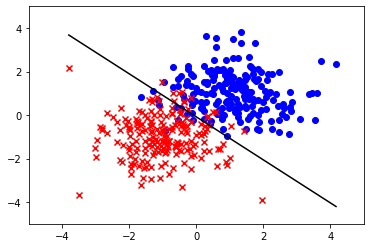

In [15]:
xp,yp,xn,yn=createdata(1)
w = linear_regression(xp,yp,xn,yn,1)

In [7]:
xp,yp,xn,yn=createdata(1)
error = 0
for i in range(xp.shape[0]):
    xpp=np.matrix(xp)
    ypp=np.matrix(yp)
    testdatax = xpp[i,:]
    testdatay = ypp[:,i]
    xpp = np.delete(xpp,i,0)
    ypp = np.delete(ypp,i)
    w = linear_regression(xpp,ypp.T,xn,yn.reshape(len(yn),1),0)
    error += int(np.sum(np.abs(np.sign(np.dot(w.reshape(1,2),testdatax.T)) - testdatay)/2)) 
for i in range(xn.shape[0]):
    xnn=np.matrix(xn)
    ynn=np.matrix(yn)
    testdatax = xnn[i,:]
    testdatay = ynn[:,i]
    xnn = np.delete(xnn,i,0)
    ynn = np.delete(ynn,i)
    w = linear_regression(xp,yp.reshape(len(yp),1),xnn,ynn.T,0)
    error += int(np.sum(np.abs(np.sign(np.dot(w.reshape(1,2),testdatax.T)) - testdatay)/2))
print("Linear regression crossvalidation error:", error,"/",xp.shape[0]+xn.shape[0],"= {:.3f} %".format(error/(xp.shape[0]+xn.shape[0])*100))

Linear regression crossvalidation error: 28 / 400 = 7.000 %


In [23]:
#Logistic_regression
#######################################
def errorf(x, y):
    if x > 0:
        if y ==1:
            return 0
        else:
            return 1
    if x <= 0:
        if y ==1:
            return 1
        else:
            return 0
##########################
def logistic_regression(xp,yp,xn,yn,d,p):
    x = np.concatenate((xp,xn))
    y = np.concatenate((yp,yn))
    y = y.tolist()
    beta = cp.Variable(d)
    log_likelihood = cp.sum(
        cp.multiply(y, x @ beta) - cp.logistic(x @ beta)
    )
    problem = cp.Problem(cp.Maximize(log_likelihood/d))
    problem.solve()
    #beta = beta.value
    errort = 0
    for i in range(len(y)):
        
        errort = errort + errorf( (x[i] @ beta).value, y[i])
    # if value is not equal, the value after subtraction would be doubled
    if p > 0:
        print("beta=",beta.value)
        plotlinear(xp,xn,beta.value,0,1)
        print("Logistic regression empirical error=","={:.3f} %".format(errort/x.shape[0]*100))
    return beta.value
#############################
def logistic_nmistregression(x,y,d):
    beta = cp.Variable(d)
    log_likelihood = cp.sum(
        cp.multiply(y, x @ beta) - cp.logistic(x @ beta)
    )
    problem = cp.Problem(cp.Maximize(log_likelihood/d))
    problem.solve(solver = SCS,verbose=True)
    #beta = beta.value
    errort = 0
    for i in range(len(y)):
        errort = errort + errorf( (x[i] @ beta).value, y[i])
    print("Logistic regression empirical error=","={:.3f} %".format(errort/x.shape[0]*100))
    return beta.value
##########################################


In [25]:
d = 784
# read data and preprocess
from mnist.loader import MNIST

mndata = MNIST('')

X_train , Y_train = mndata.load_training()
# or
X_test, Y_test = mndata.load_testing()
xp=np.empty((0,784), int)
yp=np.empty((0,1),int)
X_opt=np.empty((0,784), int)
Y_opt=np.empty((0,1),int)
for i in reversed(range(len(Y_train))):
    if Y_train[i] ==1 or Y_train[i] ==0:
        xp=np.append(xp,[X_train[i]],axis=0)
        yp=np.append(yp,[Y_train[i]])

for i in reversed(range(len(Y_test))):
    if Y_test[i] ==1 or Y_test[i] == 0:
        X_opt=np.append(X_opt,[X_test[i]],axis=0)
        Y_opt=np.append(Y_opt,[Y_test[i]])
print("start to optimize")
start = time.time()
error = 0
w = logistic_nmistregression(xp,yp,d)
print("optimization finished")
for i in range(len(Y_opt)):
    x = np.dot(w.T, X_opt[i])
    if x>0:
        if Y_opt[i]==0:
            #print("wx +b=",x,",but y is",ty)
            error = error +1
        else:
            error = error
    if x<0:
        if Y_opt[i]>0:
            error = error +1
        else:
            error = error
print("MNIST error {:.3f} %".format(error/len(Y_opt)*100))
end = time.time()
print("Time elapsed: {:.3f} ".format(end - start),"s")


start to optimize
WARN: A->p (column pointers) not strictly increasing, column 0 empty
WARN: A->p (column pointers) not strictly increasing, column 1 empty
WARN: A->p (column pointers) not strictly increasing, column 2 empty
WARN: A->p (column pointers) not strictly increasing, column 3 empty
WARN: A->p (column pointers) not strictly increasing, column 4 empty
WARN: A->p (column pointers) not strictly increasing, column 5 empty
WARN: A->p (column pointers) not strictly increasing, column 6 empty
WARN: A->p (column pointers) not strictly increasing, column 7 empty
WARN: A->p (column pointers) not strictly increasing, column 8 empty
WARN: A->p (column pointers) not strictly increasing, column 9 empty
WARN: A->p (column pointers) not strictly increasing, column 10 empty
WARN: A->p (column pointers) not strictly increasing, column 11 empty
WARN: A->p (column pointers) not strictly increasing, column 12 empty
WARN: A->p (column pointers) not strictly increasing, column 13 empty
WARN: A->p (

WARN: aa_init returned NULL, no acceleration applied.
Setup time: 1.26e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.19e+21  4.19e+22  1.00e+00 -1.80e+20  7.88e+24  7.09e+24  2.02e-01 
   100| 1.32e-03  2.89e-01  2.27e-01  9.77e+00  1.58e+01  7.47e-13  3.23e+00 
   200| 4.35e-04  5.68e-02  1.44e-01  7.39e+00  1.00e+01  2.76e-13  1.04e+01 
   300| 3.73e-04  4.66e-02  2.56e-01  5.46e+00  9.56e+00  7.17e-13  1.74e+01 
   400| 5.44e-04  1.37e-01  3.35e-01  4.01e+00  8.55e+00  7.54e-13  2.51e+01 
   500| 2.75e-04  1.31e-01  3.54e-01  3.36e+00  7.59e+00  7.92e-13  3.43e+01 
   600| 2.29e-04  1.09e-01  3.70e-01  2.87e+00  6.82e+00  3.30e-13  4.36e+01 
   700| 1.96e-04  9.21e-02  3.81e-01  2.49e+00  6.17e+00  9.46e-13  5.29e+01 
   800| 1.70e-04  7.83e-02  3.88e-01  2.19e+00  5.61e+00  8.96e-13  6

In [60]:
d=2
xp,yp,xn,yn=createdata(0)
errort = 0
start = time.time()
for i in range(xp.shape[0]):
    xpp=np.matrix(xp)
    ypp=list(yp)
    testdatax = xpp[i,:]
    testdatay = ypp[i]
    xpp = np.delete(xpp,i,0)
    ypp = np.delete(ypp,i)
    w = logistic_regression(xpp,ypp.T,xn,yn,d,0)
    errort = errort + error( (testdatax @ w), testdatay)
for i in range(xn.shape[0]):
    xnn=np.matrix(xn)
    ynn=list(yn)
    testdatax = xnn[i,:]
    testdatay = ynn[i]
    xnn = np.delete(xnn,i,0)
    ynn = np.delete(ynn,i)
    w = logistic_regression(xp,yp,xnn,ynn.T,d,0)     
    errort = errort + error( (testdatax @ w), testdatay)
print("Logistic regression crossvalidation error:","= {:.3f} %".format(errort/(xp.shape[0]+xn.shape[0])*100))
end = time.time()
print("Time elapsed: {:.3f} ".format(end - start),"s")

Logistic regression crossvalidation error: = 7.000 %
Time elapsed: 18.798  s


beta= [2.47162046 2.67992781]
Logistic regression empirical error= =7.000 %


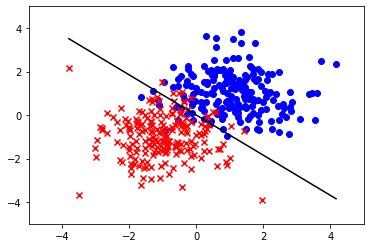

In [24]:
d=2
xp,yp,xn,yn=createdata(0)
beta = logistic_regression(xp,yp,xn,yn,d,1)